In [1]:
from threeML import *

import matplotlib.pyplot as plt

%matplotlib inline


Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!

Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incom

In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )


Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128


In [3]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6 )

In [4]:
powerlaw = Powerlaw()

In [5]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=powerlaw )

In [6]:
model = Model( GRB )

In [7]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn090217206.spectrum.main.Powerlaw.K,2.53 +/- 0.21,1 / (cm2 keV s)
1,bn090217206.spectrum.main.Powerlaw.index,-1.183 +/- 0.015,



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,-0.98
-0.98,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,869.098857
NaI6,869.098857


In [8]:
#bn090217206.spectrum.main.Powerlaw.K	2.57 -0.19 +0.22	1 / (cm2 keV s)
#bn090217206.spectrum.main.Powerlaw.index	-1.185 -0.015 +0.014	


res = jl.get_errors()

Name,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.53 -0.20 +0.21,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.183 -0.015 +0.015,


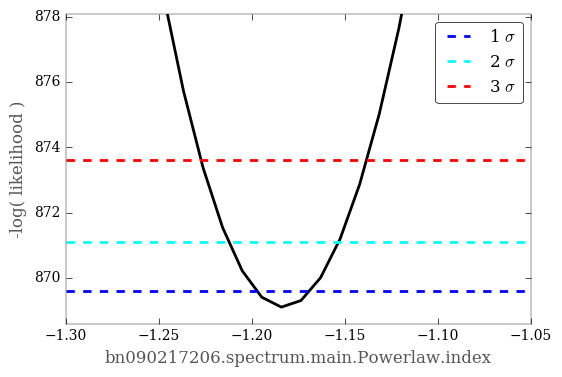

In [9]:
res = jl.get_contours(powerlaw.index,-1.3,-1.1,20)

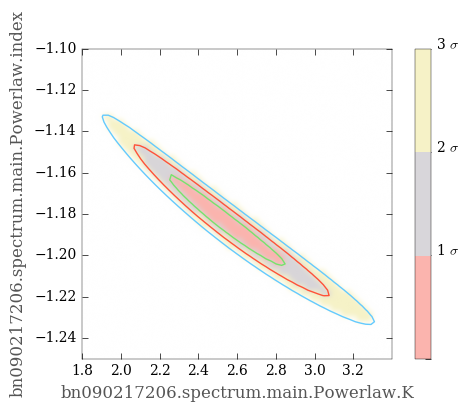

In [10]:
res = jl.get_contours(powerlaw.index,-1.25,-1.1,60,powerlaw.K,1.8,3.4,60)

In [11]:
powerlaw.index.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
powerlaw.K.prior = Log_uniform_prior(lower_bound=1.0, upper_bound=10)

bayes = BayesianAnalysis(model, data_list)

In [12]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.71434


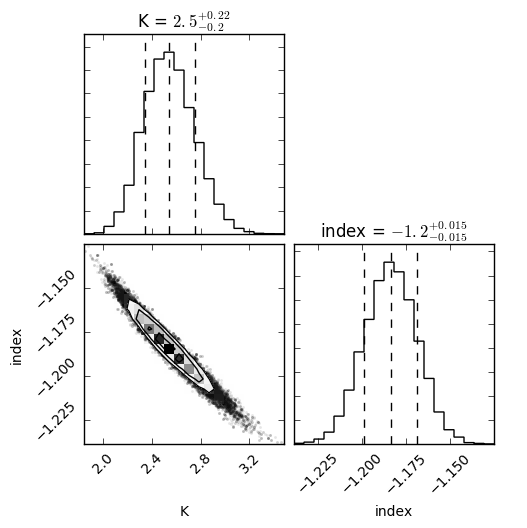

In [13]:
fig = bayes.corner_plot()